## preprocceing data and creating a model that classifies speech to one of 6 commands

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflowjs as tfjs

from tensorflow.keras import layers
from tensorflow.keras import models

import pickle

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### open dataset

In [3]:
DATASET_PATH = 'converting/recorded_words_wav'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['Back' 'Close' 'Forward' 'Home' 'Refresh' 'Tab']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 5986
Number of examples per label: 997
Example file tensor: tf.Tensor(b'converting\\recorded_words_wav\\Refresh\\540.wav', shape=(), dtype=string)


In [5]:
train_files = filenames[:4800]
val_files = filenames[4800: 4800 + 600]
test_files = filenames[-586:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 4800
Validation set size 600
Test set size 586


In [6]:
test_file = tf.io.read_file(DATASET_PATH+'/Tab/1.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([61440, 1])

In [7]:
# Decode WAV-encoded audio files to `float32` tensors, normalized
# to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels` axis from the array.
    return tf.squeeze(audio, axis=-1)
#get label for file
def get_label(file_path):
    parts = tf.strings.split(input=file_path, sep=os.path.sep)
    return parts[-2]
#compbine both functions
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [8]:
#create a data_set
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

In [9]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 60000 samples.
    input_len = 60000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([60000] - tf.shape(waveform), dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [10]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [11]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)
    return output_ds

In [12]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

for spectrogram, _ in spectrogram_ds.take(1):
      print(spectrogram.shape)

(467, 129, 1)


In [13]:
# def resizing(spectogram, label):
#     spectogram = tf.image.resize(spectogram,[32,32])
#     return spectogram, label

# train_ds = train_ds.map(map_func=resizing, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(map_func=resizing, num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.map(map_func=resizing, num_parallel_calls=AUTOTUNE)


In [14]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

for spectrogram, _ in spectrogram_ds.take(1):
      input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 3
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Input shape: (467, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [15]:
# tfjs_pa = 'latest_try/ml_model/'
# tfjs_target_dir = pathlib.Path(tfjs_pa)
# tfjs.converters.save_keras_model(model, tfjs_target_dir)

#pickle.dump(model, open('model.pkl', 'wb'))

model.save('model.h5')

Text(0, 0.5, 'Accuracy [%]')

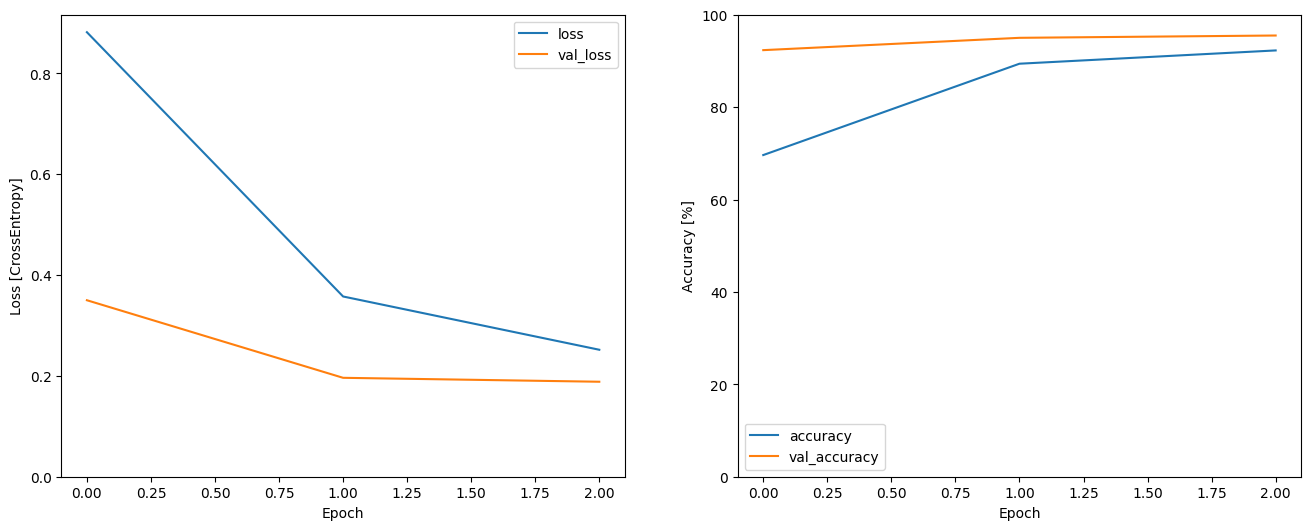

In [16]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [17]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

19/19 [==============================] - 1s 31ms/step
Test set accuracy: 95%


0


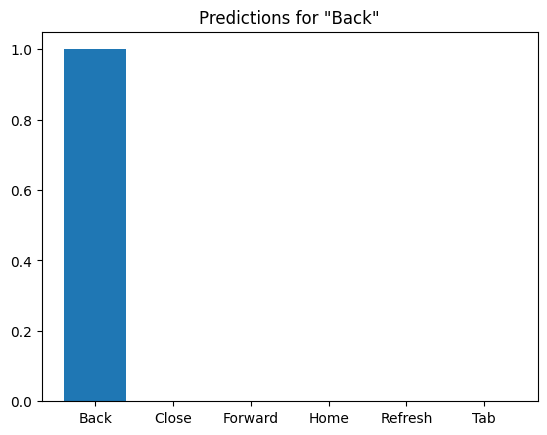

In [25]:
#DATASET_PATH = 'converting/recorded_words_wav/Tab'

DATASET_PATH = 'converting/'

data_dir_2 = pathlib.Path(DATASET_PATH)

#sample_file = data_dir_2/'122.wav'

sample_file = data_dir_2/'123_PC_L_mono.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram) 
    arr = tf.nn.softmax(prediction[0]).numpy()
    #print(type(tf.nn.softmax(prediction[0]).numpy()))
    print(arr.argmax())
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()
    